In [1]:
## Importing required libraries

import pandas as pd #for data preprocessing

#Linear Algebra
import numpy as np

from lightgbm import LGBMRegressor, LGBMClassifier
import imblearn
from tqdm import tqdm_notebook

## model building 
from sklearn.model_selection import KFold, cross_val_score

#Evaluation Metrics
from sklearn.metrics import  f1_score, classification_report, recall_score, precision_recall_fscore_support, precision_score

#Import Datetime module
from datetime import datetime

from sklearn.preprocessing import LabelEncoder # for encoding categorical variables

pd.set_option('max_column', 10000)
pd.set_option('max_row', 10000)

#Data Visualization Libraries

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

#To ignore unnecessary warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')

In [3]:
a = train[train['Year_of_Birth']<1940].index
train.drop(a, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

In [4]:
len_train = len(train)
df = pd.concat([train, test]).reset_index(drop=True)

In [5]:
###Checking for missing value
df.isnull().sum()

ID                           0
Year_of_Birth                0
Education_Level              0
Marital_Status               0
Disposable_Income           24
No_of_Kids_in_home           0
No_of_Teen_in_home           0
Date_Customer                0
Recency                      0
Discounted_Purchases         0
WebPurchases                 0
CatalogPurchases             0
StorePurchases               0
Amount_on_Wines              0
Amount_on_Fruits             0
Amount_on_MeatProducts       0
Amount_on_FishProducts       0
Amount_on_SweetProducts      0
Amount_on_GoldProds          0
WebVisitsMonth               0
Cmp3Accepted                 0
Cmp4Accepted                 0
Cmp5Accepted                 0
Cmp1Accepted                 0
Cmp2Accepted                 0
Any_Complain                 0
Response                   672
dtype: int64

# Filling missing values

In [6]:
df['Disposable_Income'] = df['Disposable_Income'].fillna(train['Disposable_Income'].median())

In [7]:
#Convert Datetime
df['Date_Customer'] = pd.to_datetime(df['Date_Customer'])

In [8]:
df['enrollment_year'] = df['Date_Customer'].dt.year
df['enrollment_month'] = df['Date_Customer'].dt.month
df['enrollment_day'] = df['Date_Customer'].dt.day

In [9]:
df.head()

,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response,enrollment_year,enrollment_month,enrollment_day
0,ID_4A9AR6FQ,1955,Graduation,Divorced,77504.4,1,1,2014-06-22,56,2,1,1,4,71,3,16,0,6,20,3,0,0,0,0,0,0,0.0,2014,6,22
1,ID_X28T3VEK,1958,Graduation,Together,56784.0,0,1,2013-01-08,17,6,5,1,8,205,22,111,50,15,19,6,0,0,0,0,0,0,0.0,2013,1,8
2,ID_AWXARH57,1962,Graduation,Single,103714.8,0,0,2013-11-21,17,0,7,4,7,469,31,873,29,18,37,2,0,0,0,1,0,0,1.0,2013,11,21
3,ID_FQVZHE81,1979,2n Cycle,Single,46311.6,1,0,2013-09-13,49,3,4,1,3,56,15,49,17,24,24,8,0,0,0,0,0,0,0.0,2013,9,13
4,ID_QVLWGPRN,1959,Graduation,Married,87486.0,0,0,2014-01-21,59,1,3,7,9,412,117,445,181,165,203,1,0,0,0,1,0,0,0.0,2014,1,21


In [10]:
## splitting the dataframe into test and train dataframe

train = df[:len_train]
test = df[len_train:]

In [11]:
#Read the first 5 columns of the train set
train.head()

,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response,enrollment_year,enrollment_month,enrollment_day
0,ID_4A9AR6FQ,1955,Graduation,Divorced,77504.4,1,1,2014-06-22,56,2,1,1,4,71,3,16,0,6,20,3,0,0,0,0,0,0,0.0,2014,6,22
1,ID_X28T3VEK,1958,Graduation,Together,56784.0,0,1,2013-01-08,17,6,5,1,8,205,22,111,50,15,19,6,0,0,0,0,0,0,0.0,2013,1,8
2,ID_AWXARH57,1962,Graduation,Single,103714.8,0,0,2013-11-21,17,0,7,4,7,469,31,873,29,18,37,2,0,0,0,1,0,0,1.0,2013,11,21
3,ID_FQVZHE81,1979,2n Cycle,Single,46311.6,1,0,2013-09-13,49,3,4,1,3,56,15,49,17,24,24,8,0,0,0,0,0,0,0.0,2013,9,13
4,ID_QVLWGPRN,1959,Graduation,Married,87486.0,0,0,2014-01-21,59,1,3,7,9,412,117,445,181,165,203,1,0,0,0,1,0,0,0.0,2014,1,21


In [12]:
#We can also use the .info method
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       1567 non-null   object        
 1   Year_of_Birth            1567 non-null   int64         
 2   Education_Level          1567 non-null   object        
 3   Marital_Status           1567 non-null   object        
 4   Disposable_Income        1567 non-null   float64       
 5   No_of_Kids_in_home       1567 non-null   int64         
 6   No_of_Teen_in_home       1567 non-null   int64         
 7   Date_Customer            1567 non-null   datetime64[ns]
 8   Recency                  1567 non-null   int64         
 9   Discounted_Purchases     1567 non-null   int64         
 10  WebPurchases             1567 non-null   int64         
 11  CatalogPurchases         1567 non-null   int64         
 12  StorePurchases           1567 non-

In [13]:
# We can separate catgorical and numerical column
#categ_cols == categorical columns . Date column excluded
categ_cols = train.select_dtypes(include=['object', 'category']).columns

# num column == numerical columns + date column included
num_cols = [col for col in train.columns if col not in categ_cols]
print(f'The Categorical Columns are: {categ_cols}')
print(f'The Numerical Columns are: {num_cols}')

The Categorical Columns are: Index(['ID', 'Education_Level', 'Marital_Status'], dtype='object')
The Numerical Columns are: ['Year_of_Birth', 'Disposable_Income', 'No_of_Kids_in_home', 'No_of_Teen_in_home', 'Date_Customer', 'Recency', 'Discounted_Purchases', 'WebPurchases', 'CatalogPurchases', 'StorePurchases', 'Amount_on_Wines', 'Amount_on_Fruits', 'Amount_on_MeatProducts', 'Amount_on_FishProducts', 'Amount_on_SweetProducts', 'Amount_on_GoldProds', 'WebVisitsMonth', 'Cmp3Accepted', 'Cmp4Accepted', 'Cmp5Accepted', 'Cmp1Accepted', 'Cmp2Accepted', 'Any_Complain', 'Response', 'enrollment_year', 'enrollment_month', 'enrollment_day']


In [14]:
for col in categ_cols:
    print(f'Unique entries in the {col} column in the train set is: {train[col].nunique()}')
    print(f'and the unique entries are: {train[col].unique()}')

Unique entries in the ID column in the train set is: 1567
and the unique entries are: ['ID_4A9AR6FQ' 'ID_X28T3VEK' 'ID_AWXARH57' ... 'ID_O11VSIJY' 'ID_VS37P6MS'
 'ID_AKHOY7EI']
Unique entries in the Education_Level column in the train set is: 5
and the unique entries are: ['Graduation' '2n Cycle' 'Master' 'PhD' 'Basic']
Unique entries in the Marital_Status column in the train set is: 8
and the unique entries are: ['Divorced' 'Together' 'Single' 'Married' 'Widow' 'Alone' 'Absurd' 'YOLO']


## Also check unique entries in Target column

In [15]:
print(f'Unique entries in the Target column in  is: {train.Response.nunique()}')
print(f'and the unique entries are: {train.Response.unique()}')

Unique entries in the Target column in  is: 2
and the unique entries are: [0. 1.]


## A visualization of some features of the train data 

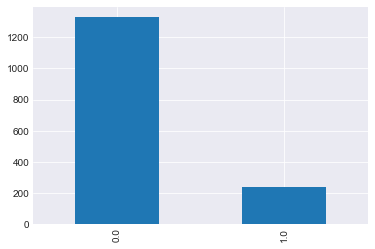

In [16]:
train.Response.value_counts().plot(kind='bar')
plt.show()

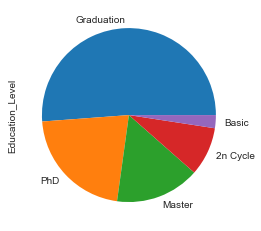

In [17]:
train.Education_Level.value_counts().plot(kind="pie")
plt.show()

<AxesSubplot:>

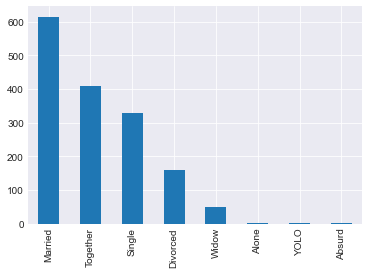

In [18]:
train.Marital_Status.value_counts().plot(kind="bar")

# Encoding Categorical Variables

In [25]:
cat_col = ['Education_Level','Marital_Status']

for i in cat_col:
    le = LabelEncoder()
    df[i] = le.fit_transform(df[i])

In [26]:
cat_col = ['Education_Level','Marital_Status']

for i in cat_col:
    le = LabelEncoder()
    train[i] = le.fit_transform(train[i])

In [27]:
cat_col = ['Education_Level','Marital_Status']

for i in cat_col:
    le = LabelEncoder()
    test[i] = le.fit_transform(test[i])

In [28]:
## splitting the train dataframe into x and y for dependent and independent features 

X = train.drop(columns=['ID','Date_Customer','Response'])
y = train['Response']
tes = test.drop(columns=['ID','Date_Customer','Response'])

In [29]:
## value count of target feature
y.value_counts()

0.0    1328
1.0     239
Name: Response, dtype: int64

In [30]:
from imblearn.over_sampling import SMOTE
seed = 50
sm = SMOTE(sampling_strategy={1:280, 0:1328}, random_state=seed) 
X_, y_ = sm.fit_resample(X, y)

# Modeling

In [32]:
%%time
from sklearn.ensemble import RandomForestClassifier
folds = KFold(n_splits=5, shuffle=True, random_state=1234)
oofs = np.zeros((len(X_)))
preds = np.zeros((len(tes)))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_, y_)):
    
    X_trn, y_trn = X_.iloc[trn_idx], y_.iloc[trn_idx]
    X_val, y_val = X_.iloc[val_idx], y_.iloc[val_idx]
    
    
    clf = LGBMClassifier(learning_rate=0.2, n_estimators=1000, scale_pos_weight=4, max_depth=-1, colsample_bytree=0.7, subsample=0.85, reg_alpha=3, reg_lambda=20)
    clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)],
                    verbose = 0, early_stopping_rounds=200)
    
    vp = clf.predict_proba(X_val)[:,1]
    b = pd.DataFrame(vp)
    b[0] = np.where(b[0]>0.5, 1, 0)
    val_score = f1_score((y_val), (b[0]))
    
    print(f'\nFold {fold_+1} Val score: {val_score}\n')
    
    tp = clf.predict_proba(tes)[:,1]
    
    oofs[val_idx] = vp
    preds += tp/5


Fold 1 Val score: 0.6722689075630253


Fold 2 Val score: 0.689655172413793


Fold 3 Val score: 0.6470588235294118


Fold 4 Val score: 0.6181818181818182


Fold 5 Val score: 0.723076923076923

Wall time: 1.58 s


In [33]:
a = pd.DataFrame(oofs)
a[0] = np.where(a[0]>0.5, 1, 0)
oof_score = f1_score((y_), (a[0]))
print(f'\nOOF F1 score is : {oof_score}')


OOF F1 score is : 0.6724436741767764


In [36]:
sub['Response'] = preds

In [37]:
sub.head()

,ID,Response
0,ID_ZPMABNVX,0.045521
1,ID_WFE91NAA,0.339706
2,ID_JV11RBRK,0.034930
3,ID_6B7SVKY9,0.705636
4,ID_GOVUZ545,0.258080


In [38]:
sub['Response'] = np.where(sub['Response']>=0.5, 1, 0)

In [39]:
sub['Response'].value_counts()

0    557
1    115
Name: Response, dtype: int64

In [40]:
sub.to_csv('m8.csv', index=False)